### 0. Overview

In [11]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from IPython.display import display
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
# from sklearn.externals import joblib
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as formula
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
warnings.filterwarnings(action='ignore')


In [3]:
file_path = '../data/raw/data-train/input/S0000137-Ngoc Khanh.csv'

In [4]:
df = pd.read_csv(file_path)

In [5]:
df = df.iloc[:, 1:]

In [7]:
df

,timestamp,PM2.5,humidity,temperature
0,27/05/2020 12:00,23.66,64.09,29.96
1,27/05/2020 13:00,23.08,63.05,30.07
2,27/05/2020 14:00,25.68,67.51,29.77
3,27/05/2020 15:00,26.37,71.17,29.11
4,27/05/2020 16:00,27.57,71.60,29.08
...,...,...,...,...
8995,06/06/2021 07:00,NaN,NaN,NaN
8996,06/06/2021 08:00,NaN,NaN,NaN
8997,06/06/2021 09:00,NaN,NaN,NaN
8998,06/06/2021 10:00,NaN,NaN,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    9000 non-null   object 
 1   PM2.5        8103 non-null   float64
 2   humidity     8319 non-null   float64
 3   temperature  8319 non-null   float64
dtypes: float64(3), object(1)
memory usage: 281.4+ KB


In [36]:
# check for duplicated values and null values
print('Are there any duplicated values in our data ? : {}\n'.format(
    df.duplicated().any()))
print('The total number of null values in each colum:')
display(df.isnull().sum())


Are there any duplicated values in our data ? : False

The total number of null values in each colum:


timestamp        0
PM2.5          897
humidity       681
temperature    681
dtype: int64

In [9]:
df['timestamp'] = pd.to_datetime(df['timestamp'])


### 1. Handle NaN values

In [6]:
# fill in the missing values with the mean of the particular column
df['PM2.5'].fillna(value = df['PM2.5'].mean(), inplace = True)
df['humidity'].fillna(value=df['humidity'].mean(), inplace=True)
df['temperature'].fillna(value=df['temperature'].mean(), inplace=True)


In [19]:
# let's check the data again if there are any missing values
df.isnull().any()


timestamp      False
PM2.5          False
humidity       False
temperature    False
dtype: bool

### 2. Check Outlier

In [1]:
def outlier_thresholds(dataframe, col_name, q1_perc=0.05, q3_perc=0.95):
    """
    given dataframe, column name, q1_percentage and q3 percentage, function calculates low_limit and up_limit

    """
    quartile1 = dataframe[col_name].quantile(q1_perc)
    quartile3 = dataframe[col_name].quantile(q3_perc)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name, q1_perc=0.01, q3_perc=0.99):
    outlier_list = []
    low_limit, up_limit = outlier_thresholds(
        dataframe, col_name, q1_perc=0.01, q3_perc=0.99)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


In [7]:
check_outlier(df, 'PM2.5')

False

<Figure size 432x288 with 0 Axes>

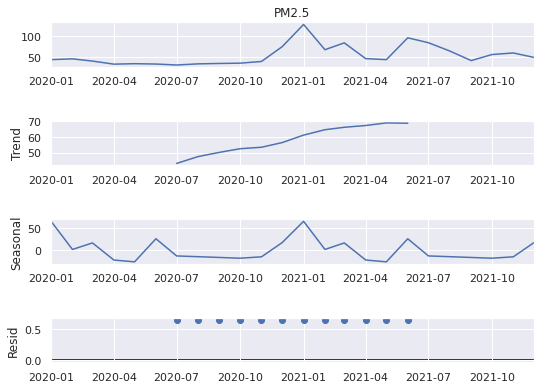

In [12]:
train_plot = df.set_index('timestamp')
y = train_plot['PM2.5'].resample('MS').mean()

result = sm.tsa.seasonal_decompose(y, model='additive')
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(8, 6)


### 3. Feature engineering

In [13]:
def create_date_features(df):
    df['month'] = df.timestamp.dt.month
    df['day_of_month'] = df.timestamp.dt.day
    df['day_of_year'] = df.timestamp.dt.dayofyear
    df['week_of_year'] = df.timestamp.dt.weekofyear
    # 1.1.2013 is Tuesday, so our starting point is the 2nd day of week
    df['day_of_week'] = df.timestamp.dt.dayofweek + 1
    df['year'] = df.timestamp.dt.year
    df["is_wknd"] = df.timestamp.dt.weekday // 4
    df['is_month_start'] = df.timestamp.dt.is_month_start.astype(int)
    df['is_month_end'] = df.timestamp.dt.is_month_end.astype(int)
    return df

In [14]:
df = create_date_features(df)
df.head()

,timestamp,PM2.5,humidity,temperature,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2020-05-27 12:00:00,23.66,64.09,29.96,5,27,148,22,3,2020,0,0,0
1,2020-05-27 13:00:00,23.08,63.05,30.07,5,27,148,22,3,2020,0,0,0
2,2020-05-27 14:00:00,25.68,67.51,29.77,5,27,148,22,3,2020,0,0,0
3,2020-05-27 15:00:00,26.37,71.17,29.11,5,27,148,22,3,2020,0,0,0
4,2020-05-27 16:00:00,27.57,71.60,29.08,5,27,148,22,3,2020,0,0,0


### 4. Scale (for regression)

In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


In [40]:
col_names = ['humidity', 'temperature']


In [41]:
ct = ColumnTransformer([
    ('Scaler', StandardScaler(), col_names)
], remainder='passthrough')


In [44]:
df[col_names] = ct.fit_transform(df[col_names])

In [ ]:
df.to_csv('../data/processed/data-train/input/S0000137-Ngoc Khanh.csv')


### Process Data

In [ ]:
!python src/data/data_processing.py